# Logistic Regression
## Dataset

### Source
W.E.L. Pena, P.R. De Massaguer, A.D.G. Zuniga, and S.H. Saraiva (2011).

"Modeling the Growth Limit of Alicyclobacillus Acidoterrestris CRA7152

in Apple Juice: Effect of pH, Brix, Temperature, and Nisin Concentration,"

Journal of Food Processing and Preservation, Vol. 35, pp. 509-517.

### Description

Presence/Absence of growth of CRA7152 in apple juice

as a function of pH (3.5-5.5), Brix (11-19), temperature (25-50C),

and Nisin concentration (0-70)


### Paper
Read paper [here](paper.pdf)


### Variables/Columns
pH   5-8

Nisin concentration  (13-16)

Temperature  22-24

Brix Concentration 30-32

Growth   40  /* 1=Yes, 0=No  */


In [117]:
library(MASS)
library(ROCR)

In [118]:
data <- read.table("apple_juice.dat",
                   sep="",
                   col.names=c("pH", "NisinConcentration", "Temperature",
                               "BrixConcentration", "Growth"))

In [119]:
head(data)

pH,NisinConcentration,Temperature,BrixConcentration,Growth
5.5,70,50,11,0
5.5,70,43,19,0
5.5,50,43,13,1
5.5,50,35,15,1
5.5,30,35,13,1
5.5,30,25,11,0


In [120]:
summary(data)
nrow(data)

print(nrow(subset(data, Growth == 1)))
print(nrow(subset(data, Growth == 0)))

jpeg("label_dist.jpg", width = 750, height = 750)
barplot(table(data$Growth), main="Response variable distribution",
       xlab="Growth")
dev.off()

       pH        NisinConcentration  Temperature    BrixConcentration
 Min.   :3.500   Min.   : 0.00      Min.   :25.00   Min.   :11.00    
 1st Qu.:4.000   1st Qu.: 0.00      1st Qu.:35.00   1st Qu.:11.00    
 Median :4.000   Median :30.00      Median :43.00   Median :13.00    
 Mean   :4.486   Mean   :35.14      Mean   :38.38   Mean   :14.24    
 3rd Qu.:5.000   3rd Qu.:50.00      3rd Qu.:43.00   3rd Qu.:15.00    
 Max.   :5.500   Max.   :70.00      Max.   :50.00   Max.   :19.00    
     Growth      
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.3514  
 3rd Qu.:1.0000  
 Max.   :1.0000  

[1] 74

[1] 26
[1] 48


pdf 
  2

In [121]:
jpeg("var_dist.jpg", width = 750, height = 750)

par(mfrow=c(2,2))
for(i in 1:4) {
    hist(data[,i], main = names(data)[i], col="gray", xlab = names(data)[i])
}

dev.off()

pdf 
  2

In [122]:
jpeg("var_box.jpg", width = 750, height = 750)
par(mfrow=c(2,2))
for(i in 1:4) {
    boxplot(data[,i], main=names(data)[i])
}
dev.off()

pdf 
  2

In [123]:
data$Growth = as.factor(data$Growth)

data[, 1:4] = scale(data[, 1:4])
head(data)

pH,NisinConcentration,Temperature,BrixConcentration,Growth
1.283955,1.2933386,1.2524532,-1.0521548,0
1.283955,1.2933386,0.4980686,1.5431604,0
1.283955,0.5514235,0.4980686,-0.4033260,1
1.283955,0.5514235,-0.3640852,0.2455028,1
1.283955,-0.1904917,-0.3640852,-0.4033260,1
1.283955,-0.1904917,-1.4417775,-1.0521548,0


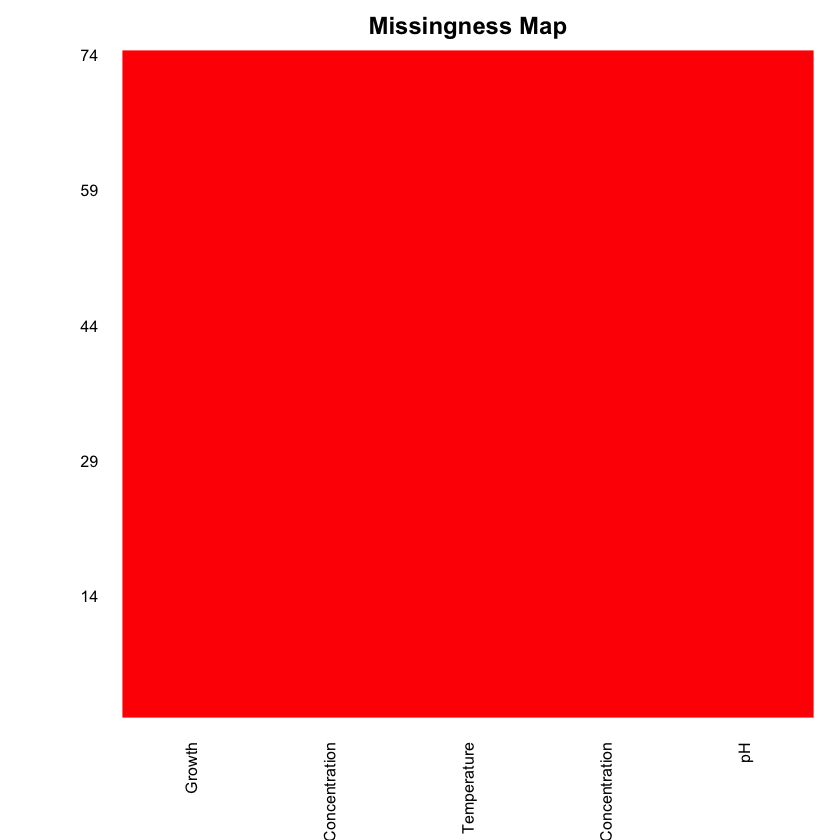

In [124]:
library(Amelia)
library(mlbench)
missmap(data, col=c("blue", "red"), legend=FALSE)

In [125]:
library(corrplot)
jpeg("corr.jpg", width = 750, height = 750)
correlations <- cor(data[,1:4])
corrplot.mixed(correlations, lower.col = "black")
#corrplot(correlations, method="circle")
dev.off()

pdf 
  2

In [126]:
jpeg("scatter.jpg", width = 750, height = 750)
pairs(data, col=data$Growth)
dev.off()

pdf 
  2

In [127]:
jpeg("density.jpg", width = 750, height = 750)
library(caret)
x <- data[,1:4]
y <- data[,5]
scales <- list(x=list(relation="free"), y=list(relation="free"))
featurePlot(x=x, y=y, plot="density", scales=scales)
dev.off()

pdf 
  2

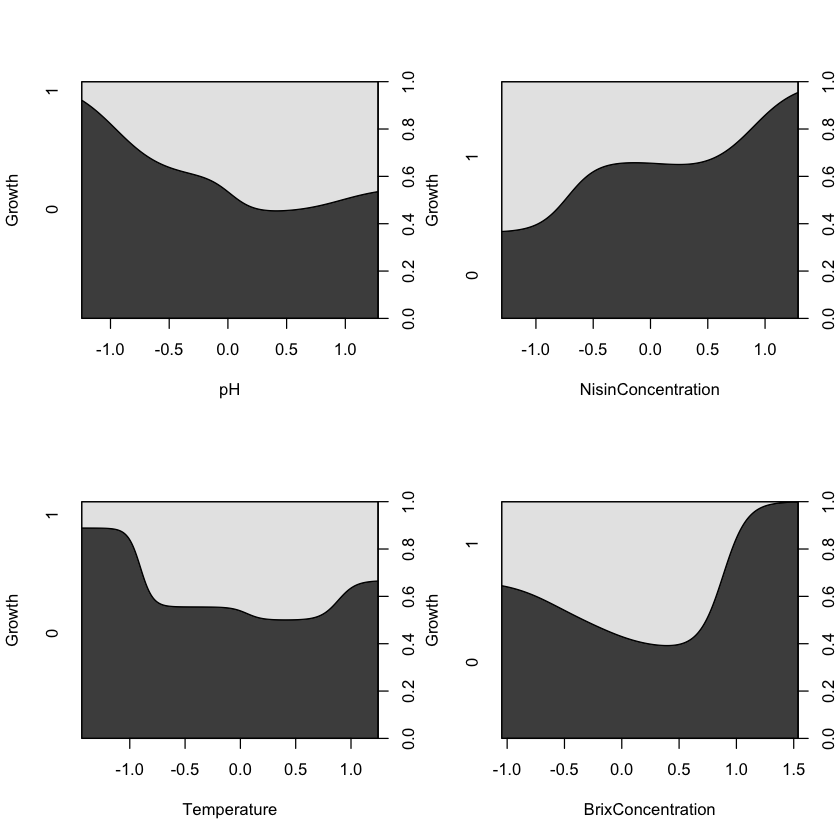

In [128]:
par(mfrow=c(2,2))
cdplot(Growth ~ pH, data = data) 
cdplot(Growth ~ NisinConcentration, data = data) 
cdplot(Growth ~ Temperature, data = data) 
cdplot(Growth ~ BrixConcentration, data = data) 

In [137]:
subsample_negative = function(data) {
    neg = subset(data, Growth == 0)
    pos = subset(data, Growth == 1)
    neg_n = nrow(neg)
    pos_n = nrow(pos)
    if (neg_n > pos_n) {
        neg_sample = neg[sample(nrow(neg), pos_n),]
        return(rbind(neg_sample, pos))
    } else {
        pos_sample = neg[sample(nrow(pos), neg_n),]
        return(rbind(neg, pos_sample))
    }
}

leave_one_out_sample = function(formula) {
    x <- c()
    y <- c()
    for (row in 1:nrow(data)) {
        test <- data[row, 1:5]
        if (row > 1) {
            if (row == nrow(data)) {
                train <- data[1:(row-1), 1:5]
            } else {
                train <- rbind(data[1:(row-1), 1:5], data[(row+1):nrow(data), 1:5])
            }
        } else {
            train <- data[(row + 1):nrow(data), 1:5]
        }
        stopifnot(nrow(train) == 73)
        train <- subsample_negative(train)
        stopifnot(nrow(train) == 50 || nrow(train) == 52)
        model.now <- glm(formula, data = train, family = binomial())
        
        fitted.results <- predict(model.now, newdata = test, type='response')
        y <- append(y, fitted.results)
        fitted.results <- ifelse(fitted.results > 0.5, 1, 0)

        #misClasificError <- mean(fitted.results != test$Growth)
        x <- append(x, fitted.results)
    }
    stopifnot(length(x) == 74)
    print(mean(x == data$Growth))

    precision <- posPredValue(as.factor(x), data$Growth, positive="1")
    print(precision)

    recall <- sensitivity(as.factor(x), data$Growth, positive="1")
    print(recall)

    F1 <- (2 * precision * recall) / (precision + recall)
    print(F1)

    pr <- prediction(y, data$Growth)
    prf <- performance(pr, measure = "tpr", x.measure = "fpr")
    
    jpeg("roc_better_model.jpg", width = 750, height = 750)
    plot(prf)
    dev.off()

    auc <- performance(pr, measure = "auc")
    auc <- auc@y.values[[1]]
    auc
}

leave_one_out_sample(Growth ~ pH + NisinConcentration + Temperature + BrixConcentration)


#model.glm.1 <- glm(Growth ~ pH + NisinConcentration + Temperature + BrixConcentration,
#                   data = data, family = binomial())
#model.glm.1
#coef(model.glm.1)

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 0.7702703
[1] 0.6363636
[1] 0.8076923
[1] 0.7118644


[1] 0.8782051

In [140]:
leave_one_out_sample(Growth ~ NisinConcentration + pH + Temperature + 
    BrixConcentration + pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration + NisinConcentration:Temperature)

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted pr

“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numer

[1] 0.9324324
[1] 0.8387097
[1] 1
[1] 0.9122807


[1] 0.9567308

In [139]:
summary(model.glm.1)


Call:
glm(formula = Growth ~ pH + NisinConcentration + Temperature + 
    BrixConcentration, family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3614  -0.3990  -0.1585   0.6306   1.6200  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.3159     0.4449  -2.958 0.003101 ** 
pH                   1.4887     0.4272   3.485 0.000493 ***
NisinConcentration  -1.7866     0.5135  -3.479 0.000503 ***
Temperature          1.0246     0.4425   2.316 0.020585 *  
BrixConcentration   -0.9609     0.4413  -2.177 0.029458 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 95.945  on 73  degrees of freedom
Residual deviance: 52.331  on 69  degrees of freedom
AIC: 62.331

Number of Fisher Scoring iterations: 6


In [103]:
jpeg("simple_model.jpg", width = 750, height = 750)
layout(matrix(1:4,ncol=2)) 
plot(model.glm.1)
dev.off()

pdf 
  2

In [104]:
# Make predictions
probabilities <- predict(model.glm.1, data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 1, 0)
# Model accuracy
mean(predicted.classes==data$Growth)

[1] 0.8378378

In [105]:
owidth={0.9\columnwidth}


ERROR: Error in parse(text = x, srcfile = src): <text>:1:12: unexpected input
1: owidth={0.9\
               ^


In [106]:
model.glm.2 <- glm(Growth ~ 1, data = data, family = binomial())
# Make predictions
probabilities <- predict(model.glm.2, data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 1, 0)
# Model accuracy
mean(predicted.classes==data$Growth)
stepAIC(model.glm.2, scope= ~ pH * NisinConcentration * Temperature * BrixConcentration)

[1] 0.6486486

Start:  AIC=97.95
Growth ~ 1

                     Df Deviance    AIC
+ NisinConcentration  1   79.412 83.412
+ pH                  1   87.248 91.248
+ BrixConcentration   1   90.572 94.572
+ Temperature         1   93.188 97.188
<none>                    95.945 97.945

Step:  AIC=83.41
Growth ~ NisinConcentration

                     Df Deviance    AIC
+ pH                  1   64.049 70.049
+ Temperature         1   73.984 79.984
+ BrixConcentration   1   76.128 82.128
<none>                    79.412 83.412
- NisinConcentration  1   95.945 97.945

Step:  AIC=70.05
Growth ~ NisinConcentration + pH

                        Df Deviance    AIC
+ Temperature            1   58.153 66.153
+ BrixConcentration      1   59.219 67.219
<none>                       64.049 70.049
+ pH:NisinConcentration  1   63.911 71.911
- pH                     1   79.412 83.412
- NisinConcentration     1   87.248 91.248

Step:  AIC=66.15
Growth ~ NisinConcentration + pH + Temperature

                        

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                       Df Deviance    AIC
+ Temperature:BrixConcentration         1   21.953 37.953
<none>                                      38.143 52.143
+ pH:Temperature                        1   36.183 52.183
+ NisinConcentration:Temperature        1   37.696 53.696
+ pH:NisinConcentration                 1   37.852 53.852
- NisinConcentration:BrixConcentration  1   48.371 60.371
- pH:BrixConcentration                  1   48.741 60.741
- Temperature                           1   52.501 64.501


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=37.95
Growth ~ NisinConcentration + pH + Temperature + BrixConcentration + 
    pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                       Df Deviance    AIC
+ NisinConcentration:Temperature        1    0.000 18.000
+ pH:Temperature                        1    0.000 18.000
<none>                                      21.953 37.953
+ pH:NisinConcentration                 1   20.978 38.978
- Temperature:BrixConcentration         1   38.143 52.143
- pH:BrixConcentration                  1   40.323 54.323
- NisinConcentration:BrixConcentration  1   47.018 61.018


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=18
Growth ~ NisinConcentration + pH + Temperature + BrixConcentration + 
    pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration + NisinConcentration:Temperature



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                                                   Df Deviance    AIC
<none>                                                   0.000 18.000
+ NisinConcentration:Temperature:BrixConcentration  1    0.000 20.000
+ pH:Temperature                                    1    0.000 20.000
+ pH:NisinConcentration                             1    0.000 20.000
- NisinConcentration:Temperature                    1   21.953 37.953
- Temperature:BrixConcentration                     1   37.696 53.696
- pH:BrixConcentration                              1   39.843 55.843
- NisinConcentration:BrixConcentration              1   46.601 62.601



Call:  glm(formula = Growth ~ NisinConcentration + pH + Temperature + 
    BrixConcentration + pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration + NisinConcentration:Temperature, 
    family = binomial(), data = data)

Coefficients:
                         (Intercept)                    NisinConcentration  
                             -273.63                               -616.67  
                                  pH                           Temperature  
                              590.68                                463.57  
                   BrixConcentration                  pH:BrixConcentration  
                              -87.08                               -253.92  
NisinConcentration:BrixConcentration         Temperature:BrixConcentration  
                              533.99                               -284.34  
      NisinConcentration:Temperature  
                             -228.25  

Degrees of Freedom: 73 T

In [107]:
model.best <- glm(formula = Growth ~ NisinConcentration + pH + Temperature + 
    BrixConcentration + pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration + NisinConcentration:Temperature,
    family = binomial(), data = data)

model.best

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:  glm(formula = Growth ~ NisinConcentration + pH + Temperature + 
    BrixConcentration + pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration + NisinConcentration:Temperature, 
    family = binomial(), data = data)

Coefficients:
                         (Intercept)                    NisinConcentration  
                             -273.63                               -616.67  
                                  pH                           Temperature  
                              590.68                                463.57  
                   BrixConcentration                  pH:BrixConcentration  
                              -87.08                               -253.92  
NisinConcentration:BrixConcentration         Temperature:BrixConcentration  
                              533.99                               -284.34  
      NisinConcentration:Temperature  
                             -228.25  

Degrees of Freedom: 73 T

In [108]:
summary(model.best)


Call:
glm(formula = Growth ~ NisinConcentration + pH + Temperature + 
    BrixConcentration + pH:BrixConcentration + NisinConcentration:BrixConcentration + 
    Temperature:BrixConcentration + NisinConcentration:Temperature, 
    family = binomial(), data = data)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-1.377e-04  -2.100e-08  -2.100e-08   2.100e-08   1.685e-04  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)
(Intercept)                           -273.63   27876.50  -0.010    0.992
NisinConcentration                    -616.67   62926.85  -0.010    0.992
pH                                     590.68   60645.30   0.010    0.992
Temperature                            463.57   47482.32   0.010    0.992
BrixConcentration                      -87.08   10211.82  -0.009    0.993
pH:BrixConcentration                  -253.92   26088.25  -0.010    0.992
NisinConcentration:BrixConcentration   533.99   54777.48  

In [109]:
coef(model.best)

(Intercept)                   NisinConcentration 
                          -273.62510                           -616.66733 
                                  pH                          Temperature 
                           590.68087                            463.57290 
                   BrixConcentration                 pH:BrixConcentration 
                           -87.07795                           -253.92241 
NisinConcentration:BrixConcentration        Temperature:BrixConcentration 
                           533.99146                           -284.34442 
      NisinConcentration:Temperature 
                          -228.25223

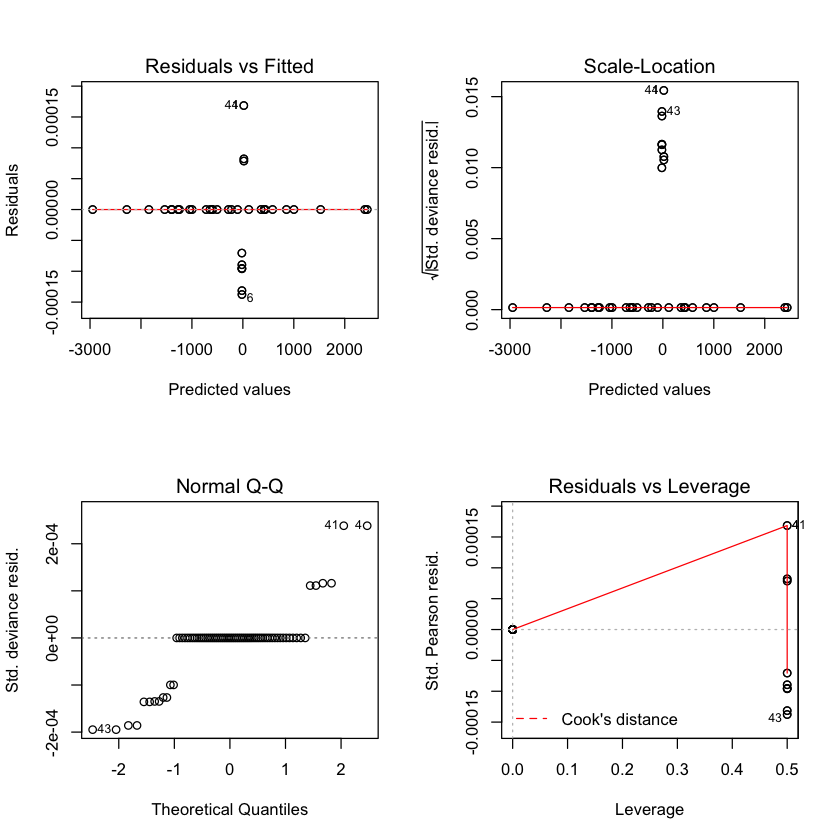

In [110]:
layout(matrix(1:4,ncol=2)) 
plot(model.best)

In [111]:
# Make predictions
probabilities <- predict(model.best, data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 1, 0)
# Model accuracy
mean(predicted.classes==data$Growth)

[1] 1

In [112]:
model.all <- glm(formula = Growth ~.,
    family = binomial(), data = data)
model.all


Call:  glm(formula = Growth ~ ., family = binomial(), data = data)

Coefficients:
       (Intercept)                  pH  NisinConcentration         Temperature  
           -1.3159              1.4887             -1.7866              1.0246  
 BrixConcentration  
           -0.9609  

Degrees of Freedom: 73 Total (i.e. Null);  69 Residual
Null Deviance:	    95.95 
Residual Deviance: 52.33 	AIC: 62.33

In [113]:
model.all$coef

(Intercept)                 pH NisinConcentration        Temperature 
        -1.3159129          1.4887102         -1.7866264          1.0246189 
 BrixConcentration 
        -0.9609079

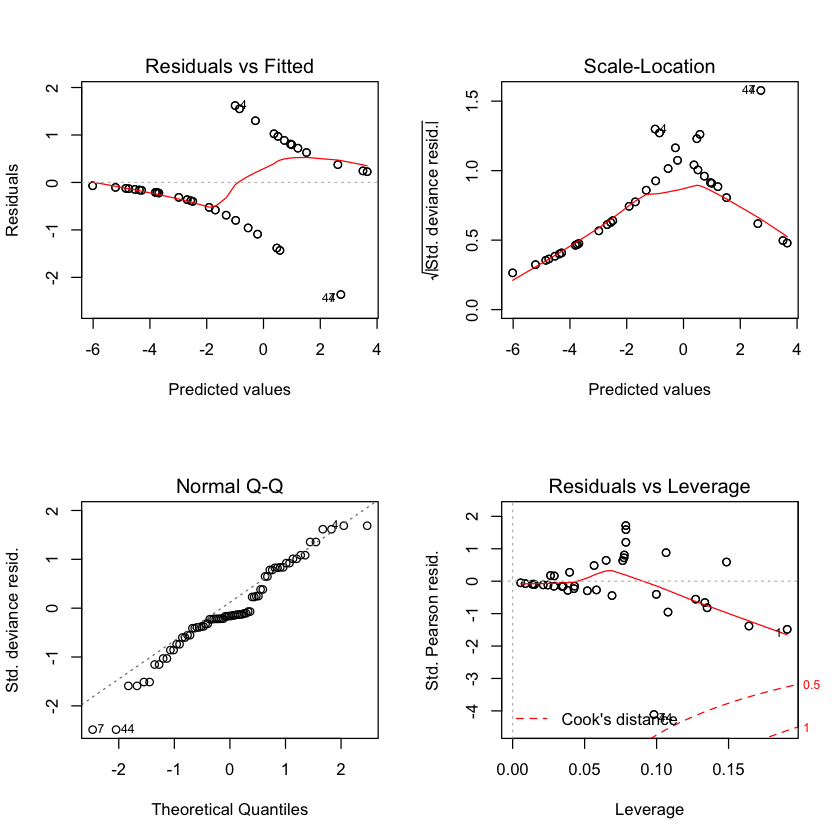

In [86]:
layout(matrix(1:4,ncol=2)) 
plot(model.all)

In [87]:
# Make predictions
probabilities <- predict(model.all, data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 1, 0)
# Model accuracy
mean(predicted.classes==data$Growth)

[1] 0.8378378